<a href="https://colab.research.google.com/github/Pavithra2625/Toxic_Tweet_Detector/blob/main/Toxic_Tweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
df=pd.read_csv("/content/train.csv")

In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv("/content/train.csv")

# Display first few rows
print(df.head())

# Check dataset info
print(df.info())




   count  hate_speech_count  offensive_language_count  neither_count  class  \
0      3                  0                         0              3      2   
1      3                  0                         3              0      1   
2      3                  0                         3              0      1   
3      3                  0                         2              1      1   
4      6                  0                         6              0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --

In [ ]:
# Map classes: 0 = hate, 1 = offensive => Toxic (1), 2 = neither => Non-Toxic (0)
df['label'] = df['class'].apply(lambda x: 0 if x==2 else 1)

# Check label distribution
print(df['label'].value_counts())


label
1    20620
0     4163
Name: count, dtype: int64


In [ ]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)        # Remove URLs
    text = re.sub(r"@\w+|#", "", text)                # Remove mentions & hashtags
    text = re.sub(r"[^a-zA-Z ]", "", text)            # Remove punctuation/numbers
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

# Apply cleaning
df['clean_tweet'] = df['tweet'].apply(clean_text)

# View sample cleaned tweets
print(df[['tweet','clean_tweet']].head())



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                               tweet  \
0  !!! RT @mayasolovely: As a woman you shouldn't...   
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...   
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...   
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...   
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...   

                                         clean_tweet  
0  rt woman shouldnt complain cleaning house amp ...  
1  rt boy dats coldtyga dwn bad cuffin dat hoe st...  
2  rt dawg rt ever fuck bitch start cry confused ...  
3                                rt look like tranny  
4  rt shit hear might true might faker bitch told ya  


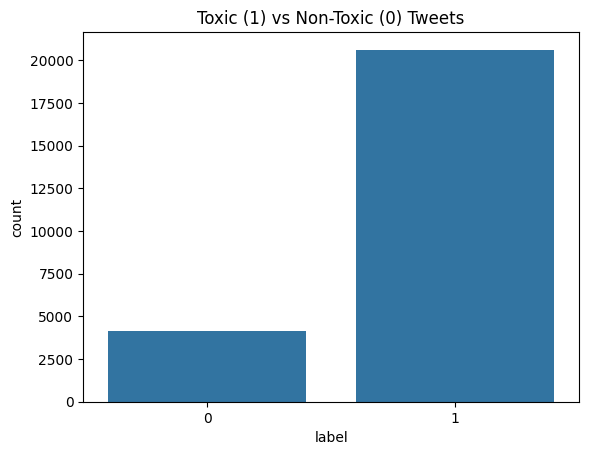

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Distribution of labels
sns.countplot(x='label', data=df)
plt.title('Toxic (1) vs Non-Toxic (0) Tweets')
plt.show()



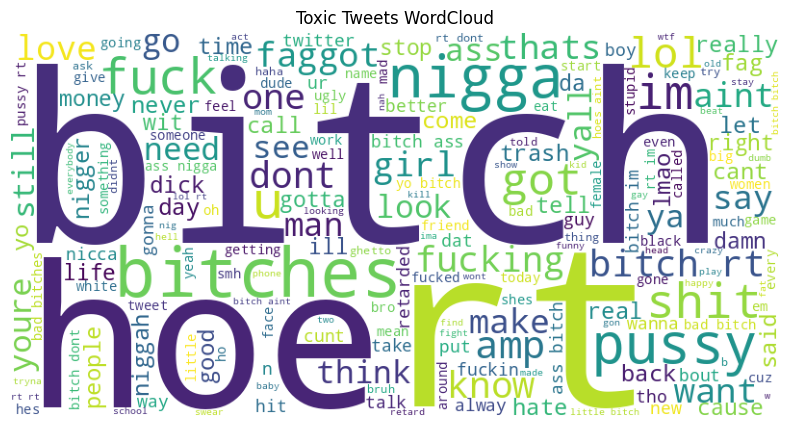

In [ ]:
# WordCloud for toxic tweets
toxic_words = ' '.join(df[df['label']==1]['clean_tweet'])
wc = WordCloud(width=800, height=400, background_color='white').generate(toxic_words)

plt.figure(figsize=(10,5))
plt.imshow(wc)
plt.axis("off")
plt.title("Toxic Tweets WordCloud")
plt.show()



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

X = df['clean_tweet']
y = df['label']

# Convert text to numerical features
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

print("TF-IDF shape:", X_tfidf.shape)


TF-IDF shape: (24783, 5000)


In [ ]:
from sklearn.model_selection import train_test_split

# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (19826, 5000)
Test size: (4957, 5000)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)


MultinomialNB()

Logistic Regression Accuracy: 0.934032681057091
              precision    recall  f1-score   support

           0       0.86      0.72      0.79       835
           1       0.95      0.98      0.96      4122

    accuracy                           0.93      4957
   macro avg       0.90      0.85      0.87      4957
weighted avg       0.93      0.93      0.93      4957

Naive Bayes Accuracy: 0.8870284446237644
              precision    recall  f1-score   support

           0       0.90      0.37      0.53       835
           1       0.89      0.99      0.94      4122

    accuracy                           0.89      4957
   macro avg       0.89      0.68      0.73      4957
weighted avg       0.89      0.89      0.87      4957



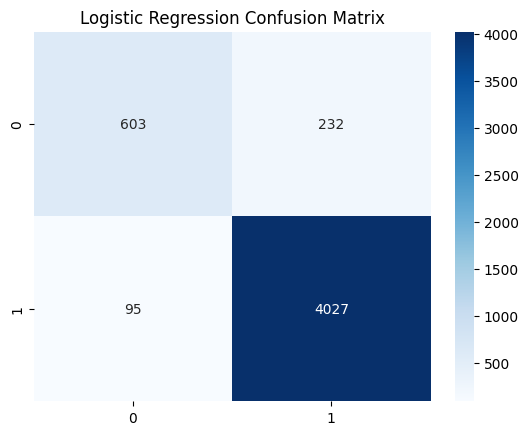

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Logistic Regression Evaluation
y_pred_lr = lr.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

# Naive Bayes Evaluation
y_pred_nb = nb.predict(X_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.show()


In [ ]:
def predict_tweet(text):
    clean = clean_text(text)
    vector = vectorizer.transform([clean])
    pred = lr.predict(vector)[0]
    return "Toxic" if pred==1 else "Non-Toxic"

# Test predictions
sample_tweets = [
    "I hate you so much!",
    "Have a wonderful day!",
    "You are the worst person ever!"
]

for tweet in sample_tweets:
    print(f"Tweet: {tweet} -> {predict_tweet(tweet)}")


Tweet: I hate you so much! -> Toxic
Tweet: Have a wonderful day! -> Non-Toxic
Tweet: You are the worst person ever! -> Toxic
